# **Summary**

**1. Business Problem Definition**

Food delivery services operate in dynamic environments where various factors influence delivery time, including traffic conditions, distance, and weather. Understanding the causal impact of weather on delivery time is critical for optimizing driver assignments and managing customer expectations.

This project aims to answer the question: **Does unfavorable weather cause an increase in food delivery time?**

By leveraging causal inference, , we can move beyond simple correlations and estimate the actual causal effect of bad weather on delivery duration. This insight can help:

1. Optimize Delivery Logistics: Restaurants and delivery platforms can adjust estimated delivery times dynamically based on expected weather-related delays.
2. Improve Resource Allocation: Companies can allocate more delivery drivers or adjust pricing strategies during unfavorable weather conditions.
3. Enhance Customer Satisfaction: More accurate delivery time predictions can improve transparency, reducing frustration caused by unexpected delays.

After building a structured methodology, We can expand the analysis to other influencing factors such as geographic location, order type, and driver ratings. This will allow for even more granular insights into delivery time variability.

**2. Hypothesis**

Unfavorable weather conditions (e.g. haze, fog, overcast clouds, etc.) increase food delivery time compared to favorable weather conditions (clear sky, few clouds, or scattered clouds)

*   Null Hypothesis (H₀): Weather conditions have no significant impact on food
delivery time.
*   Alternative Hypothesis (H₁): Unfavorable weather conditions (treatment = 1) lead to longer delivery times compared to favorable conditions (treatment = 0).

**3. [Dataset (Source: Kaggle)](https://www.kaggle.com/datasets/gautamdeora7/food-delivery-time-a-multi-factor-dataset)**

The dataset contains various factors that influence food delivery time, including:

*   Treatment Feature: Weather_description
*   Target: Delivery_time (in minutes)
*   Control Features:
 *   Other Weather Condition Factors: Temperature, Humidity, Precipitation
 *   Geograpic Factors: Restaurant_latitude, Restaurant_longitude, Delivery_location_latitude, Delivery_location_longitude, Distance (km), Traffic_Level

 *   Order Factors: Type_of_order (Category of food ordered)
 *   Driver Factors: Type_of_vehicle, Delivery_person_Age, Delivery_person_Ratings

This dataset allows for causal inference by controlling for confounding variables, helping to isolate the effect of unfavorable weather conditions on delivery time.

**4. Interpretation of Results**

The results of LRSRegressor (ATE=1.83), XGBTRegressor (ATE=1.46), and BaseXRegressor (ATE=1.55) all suggest that, on average, unfavorable weather conditions increase delivery time compared to favorable weather conditions.

While weather conditions affect delivery time, they are not the sole cause of delays. By combining insights from feature importance and Shapley values, we can derive the following key findings:

*   Distance (km): As a strong predictor, higher distances increase delivery time significantly
*   Destination and Restaurant Location: Delivery times may vary by location. For example, orders from restaurants near Cluster 1 tend to have longer delivery times.
*   Temperature and Humidity: Could impact driving conditions.
*   Traffic Level (Very High): Increased congestion may lead to higher delays.

Moreover, CATE analysis shows that ATE varies by distance, with shorter trips experiencing greater weather-induced delays than longer ones. This suggests that for short-distance deliveries, bad weather disproportionately increases travel time, possibly due to factors such as increased caution by drivers or more frequent stops. In contrast, for longer trips, the relative impact of weather on total delivery time is smaller, potentially because longer routes provide more opportunities for drivers to adjust their speed and route choices to mitigate delays.

**5. DoWhy - refutation**

*   Estimated Effect with True Treatment:
Unfavorable weather conditions increase delivery time by about 3.47 minutes.

*   New Effect with Placebo Treatment:
When a random placebo treatment is used, the estimated effect is -0.015, which is very close to zero. This suggests that when treatment is assigned randomly (instead of based on actual weather conditions), there is no meaningful impact on delivery time.

*   High p-value:
A high p-value means that the placebo treatment’s effect is not statistically significant, indicating the observed causal effect in the actual model is not due to random variation.

The placebo treatment has no significant effect, confirming that the observed impact of bad weather on delivery time is likely genuine and not an artifact of the model.

--> The original causal estimate is robust.

# **Causal Inference**

In [1]:
# !pip install causalml
# !pip install duecredit
# !pip install dowhy

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

In [3]:
df_delivery = pd.read_csv("food_delivery_time_data.csv")
df_delivery.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,temperature,humidity,precipitation,weather_description,Traffic_Level,Distance (km),TARGET
0,4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,17.11,77.0,0.0,haze,Low,NaN,21.66666667
1,B379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,19.50,93.0,0.0,mist,Very High,37.17,85.26666667
2,5D6D,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,20.45,91.0,0.0,mist,Low,3.34,28.58333333
3,7A6A,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,23.86,78.0,0.0,mist,Moderate,10.05,35.18333333
4,70A2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,26.55,87.0,0.0,mist,High,9.89,43.45


## Preprocessing

In [4]:
# Drop NULL values in the target (delivery time)
df_delivery = df_delivery.replace("#VALUE!", pd.NA).dropna(subset='TARGET', ignore_index=True)
df_delivery['TARGET'] = df_delivery['TARGET'].astype(float)
df_delivery.rename(columns={'TARGET': 'Delivery_time'}, inplace=True)

# Drop irrelevant columns
df_delivery.drop(['ID', 'Delivery_person_ID'], axis=1, inplace=True)

df_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9040 entries, 0 to 9039
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          9040 non-null   float64
 1   Delivery_person_Ratings      9040 non-null   float64
 2   Restaurant_latitude          9040 non-null   float64
 3   Restaurant_longitude         9040 non-null   float64
 4   Delivery_location_latitude   9040 non-null   float64
 5   Delivery_location_longitude  9040 non-null   float64
 6   Type_of_order                9040 non-null   object 
 7   Type_of_vehicle              9040 non-null   object 
 8   temperature                  9040 non-null   float64
 9   humidity                     9040 non-null   float64
 10  precipitation                9040 non-null   float64
 11  weather_description          9040 non-null   object 
 12  Traffic_Level                9040 non-null   object 
 13  Distance (km)     

In [5]:
missing_counts = df_delivery.isna().sum()
missing_counts.sort_values()

,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Type_of_order,0
Type_of_vehicle,0
temperature,0
humidity,0


### Numerical Attributes

In [6]:
df_delivery.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,temperature,humidity,precipitation,Distance (km),Delivery_time
count,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9035.000000,9040.000000
mean,29.513274,4.625664,18.872296,76.963167,18.936058,77.026930,22.623100,64.596239,0.000377,14.275582,37.656750
std,5.691913,0.323345,5.455883,3.546761,5.457929,3.546696,3.356855,15.370802,0.018311,8.372376,16.555938
min,15.000000,1.000000,9.957144,72.768726,9.967144,72.778726,6.770000,27.000000,0.000000,1.550000,5.800000
25%,25.000000,4.500000,12.981615,73.898520,13.062161,73.947902,19.940000,52.000000,0.000000,7.610000,25.566667
50%,29.000000,4.700000,19.055831,76.619103,19.113383,76.672278,22.860000,65.000000,0.000000,13.400000,35.983333
75%,34.000000,4.800000,22.750040,78.368855,22.815748,78.405883,25.000000,73.000000,0.000000,19.590000,47.633333
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,29.050000,94.000000,1.460000,59.840000,157.750000


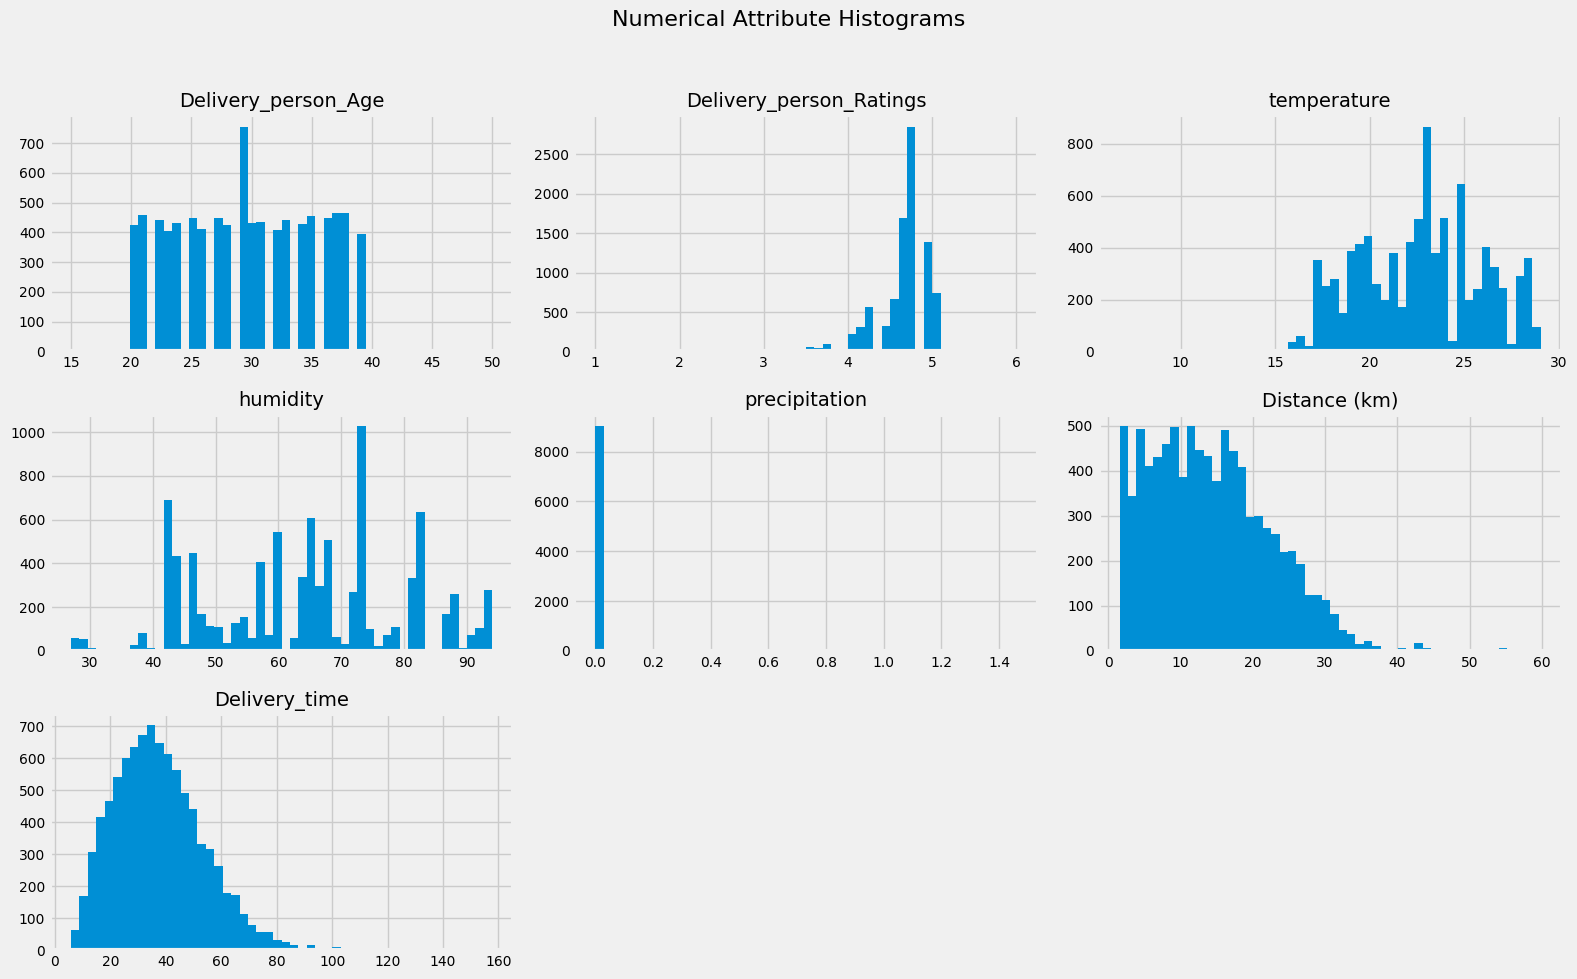

In [7]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

geo_columns = ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']
numerical_cols = df_delivery.select_dtypes(include=['number']).columns
numerical_cols = [col for col in numerical_cols if col not in geo_columns]

df_delivery[numerical_cols].hist(bins=50, figsize=(16, 10))
plt.suptitle('Numerical Attribute Histograms', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Calculate missing value of "distance"

In [8]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return round(distance, 4)

df_delivery['Distance (km)'] = df_delivery.apply(
    lambda row: calculate_distance(
        row['Restaurant_latitude'], row['Restaurant_longitude'],
        row['Delivery_location_latitude'], row['Delivery_location_longitude']
    ) if pd.isna(row['Distance (km)']) else round(row['Distance (km)'], 4),
    axis=1
)

Most of the values in "precipitation" are 0 --> convert to categorical attribute

In [9]:
df_delivery['precipitation (cat)'] = df_delivery['precipitation'].apply(lambda x: 1 if x > 0 else 0)
df_delivery.drop(['precipitation'], axis=1, inplace=True)

Cluster similarities of restaurant location and destination location

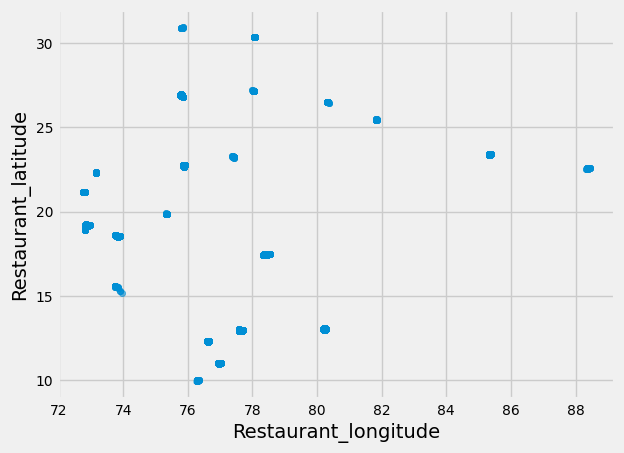

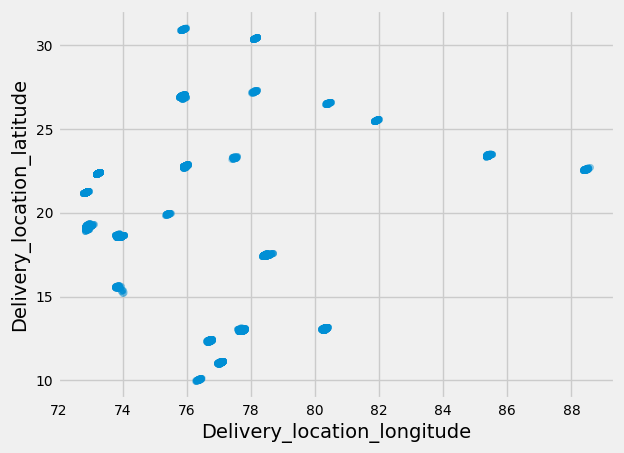

In [10]:
df_delivery.plot(kind="scatter", x="Restaurant_longitude", y="Restaurant_latitude", grid=True, alpha=0.2)
df_delivery.plot(kind="scatter", x="Delivery_location_longitude", y="Delivery_location_latitude", grid=True, alpha=0.2)
plt.show()

In [11]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [12]:
cluster_simil_restaurant = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities_restaurant = cluster_simil_restaurant.fit_transform(df_delivery[["Restaurant_latitude", "Restaurant_longitude"]],
                                                                 sample_weight=df_delivery["Delivery_time"])
restaurant_similarities_df = pd.DataFrame(similarities_restaurant, columns=cluster_simil_restaurant.get_feature_names_out())
restaurant_similarities_df.columns = [f"Restaurant - {col}" for col in restaurant_similarities_df.columns]
df_delivery = pd.concat([df_delivery, restaurant_similarities_df], axis=1)

cluster_simil_dest = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities_dest = cluster_simil_dest.fit_transform(df_delivery[["Delivery_location_latitude", "Delivery_location_longitude"]],
                                                                 sample_weight=df_delivery["Delivery_time"])
dest_similarities_df = pd.DataFrame(similarities_dest, columns=cluster_simil_dest.get_feature_names_out())
dest_similarities_df.columns = [f"Destination - {col}" for col in dest_similarities_df.columns]
df_delivery = pd.concat([df_delivery, dest_similarities_df], axis=1)

df_delivery.drop(columns=['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'], inplace=True)

### Categorical Attributes

In [13]:
df_delivery['weather_description'].value_counts()

,count
weather_description,
clear sky,3211
haze,2378
mist,1740
broken clouds,532
smoke,498
scattered clouds,409
overcast clouds,182
fog,49
few clouds,40


In [14]:
df_delivery['Type_of_order'].value_counts()

,count
Type_of_order,
Snack,2310
Meal,2281
Drinks,2276
Buffet,2173


In [15]:
df_delivery['Type_of_vehicle'].value_counts()

,count
Type_of_vehicle,
motorcycle,5350
scooter,2971
electric_scooter,709
bicycle,10


In [16]:
df_delivery['Traffic_Level'].value_counts()

,count
Traffic_Level,
High,2730
Moderate,2212
Very High,1748
Low,1718
Very Low,632


In [17]:
df_delivery['precipitation (cat)'].value_counts()

,count
precipitation (cat),
0,9033
1,7


In [18]:
categorical_cols = ['Type_of_order', 'Type_of_vehicle', 'Traffic_Level']

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_array = encoder.fit_transform(df_delivery[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

df_delivery.drop(columns=categorical_cols, inplace=True)
df_delivery = pd.concat([df_delivery, encoded_df], axis=1)

In [19]:
df_delivery.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'temperature',
       'humidity', 'weather_description', 'Distance (km)', 'Delivery_time',
       'precipitation (cat)', 'Restaurant - Cluster 0 similarity',
       'Restaurant - Cluster 1 similarity',
       'Restaurant - Cluster 2 similarity',
       'Restaurant - Cluster 3 similarity',
       'Restaurant - Cluster 4 similarity',
       'Restaurant - Cluster 5 similarity',
       'Restaurant - Cluster 6 similarity',
       'Restaurant - Cluster 7 similarity',
       'Restaurant - Cluster 8 similarity',
       'Restaurant - Cluster 9 similarity',
       'Destination - Cluster 0 similarity',
       'Destination - Cluster 1 similarity',
       'Destination - Cluster 2 similarity',
       'Destination - Cluster 3 similarity',
       'Destination - Cluster 4 similarity',
       'Destination - Cluster 5 similarity',
       'Destination - Cluster 6 similarity',
       'Destination - Cluster 7 similarity',
       'Destination - Cluster

## Treatment Feature: weather_description

In [20]:
df_delivery['group_key'] = df_delivery['weather_description'].apply(lambda x: 'Control' if x in ['clear sky', 'few clouds', 'scattered clouds'] else 'Treatment')

In [21]:
df_delivery.pivot_table(values = 'Delivery_time',
                        index = 'group_key',
                        aggfunc = [np.mean, np.size],
                        margins = True)

,mean,size
,Delivery_time,Delivery_time
group_key,,
Control,39.620624,3660
Treatment,36.320731,5380
All,37.656750,9040


In [22]:
df_delivery.drop(columns=['weather_description'], inplace=True)

## Feature Importance

Target: Delivery_time

Treatment feature: weather_description

Control features: A/O

In [23]:
treatment = df_delivery['group_key'].apply(lambda x: 1 if x == 'Treatment' else 0)
y = df_delivery['Delivery_time']
X = df_delivery.drop(['group_key', 'Delivery_time'], axis=1)

p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

### 1. LGBMRegressor

In [24]:
s_learner = BaseSRegressor(LGBMRegressor(random_state=42))
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor(random_state=42))
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor(random_state=42))
x_ate = x_learner.estimate_ate(X=X, p=p, treatment=treatment, y=y)[0][0]
x_ite = x_learner.fit_predict(X=X, p=p, treatment=treatment, y=y)

r_learner = BaseRRegressor(LGBMRegressor(random_state=42))
r_ate = r_learner.estimate_ate(X=X, p=p, treatment=treatment, y=y)[0][0]
r_ite = r_learner.fit_predict(X=X, p=p, treatment=treatment, y=y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 9040, number of used features: 38
[LightGBM] [Info] Start training from score 37.656750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 9040, number of used features: 38
[LightGBM] [Info] Start training from score 37.656750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [25]:
df_preds = pd.DataFrame([s_ite.ravel(),
                         t_ite.ravel(),
                         x_ite.ravel(),
                         r_ite.ravel(),
                         treatment.ravel(),
                         y.ravel()],
                       index=['S','T','X','R','w','y']).T

df_cumgain = get_cumgain(df_preds)
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate],
                     index=['S','T','X','R'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

df_result

,ATE,AUUC
S,1.118195,-0.171664
T,1.141654,0.077226
X,1.546423,0.111184
R,0.078816,-0.095603


X-learner performs best with best AUUC (0.111), indicating it ranks individuals effectively for intervention.

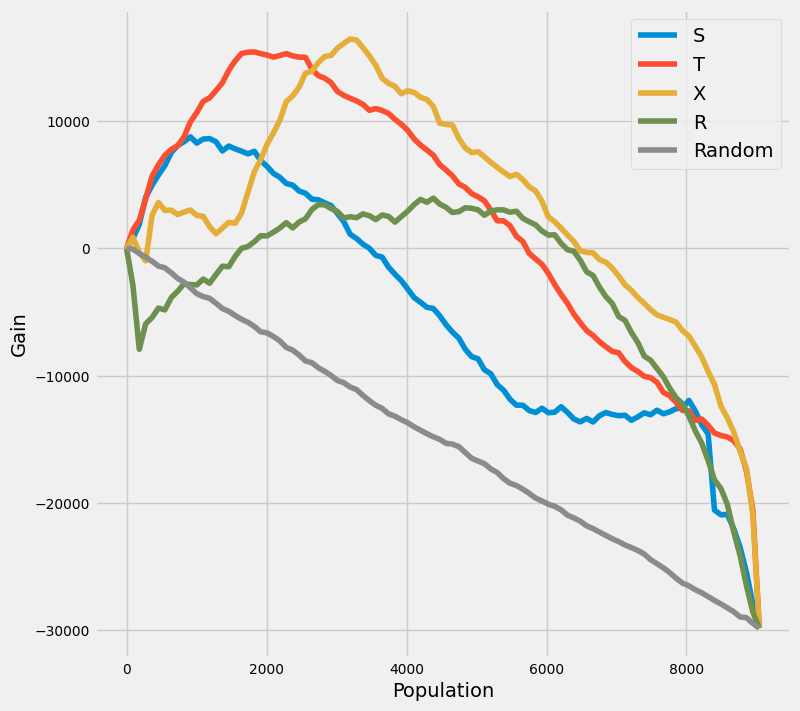

In [26]:
plot_gain(df_preds)

X is the best model, achieving the highest cumulative gain.

In [27]:
df_cate = pd.DataFrame(X)
df_cate["ITE"] = x_ite
df_cate['Distance'] = df_cate['Distance (km)'].apply(lambda x: 'Close' if x <= 10 else ('Far' if x > 20 else 'Medium'))

cate_by_distance = df_cate.groupby("Distance")["ITE"].agg(CATE='mean')
cate_by_distance

,CATE
Distance,
Close,1.804838
Far,1.082998
Medium,1.593752


#### Feature Importance

In [28]:
base_algo = LGBMRegressor()
xlearner_tau = x_learner.fit_predict(X, treatment, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4568
[LightGBM] [Info] Number of data points in the train set: 3660, number of used features: 37
[LightGBM] [Info] Start training from score 39.620624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4279
[LightGBM] [Info] Number of data points in the train set: 5380, number of used features: 37
[LightGBM] [Info] Start training from score 36.320731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

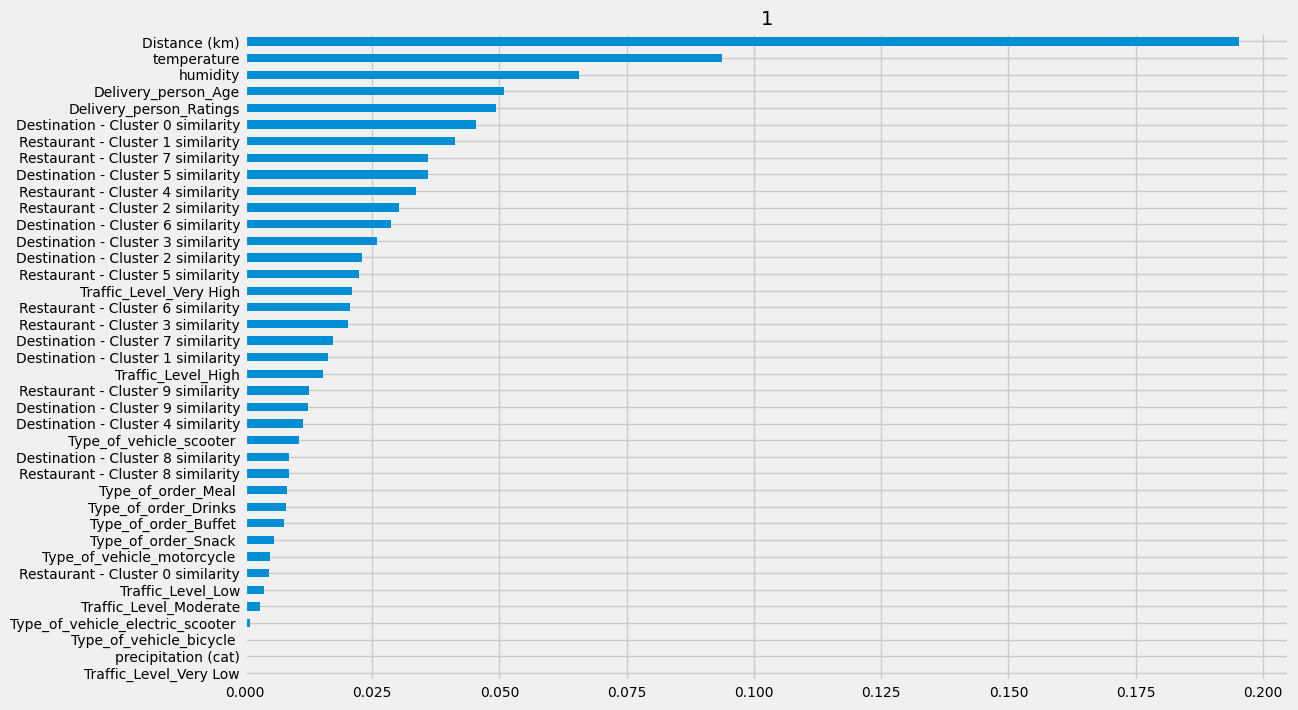

In [29]:
# method='auto'
x_learner.plot_importance(X=X, tau=xlearner_tau, model_tau_feature=base_algo,
                          normalize=True, method='auto', features=X.columns)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

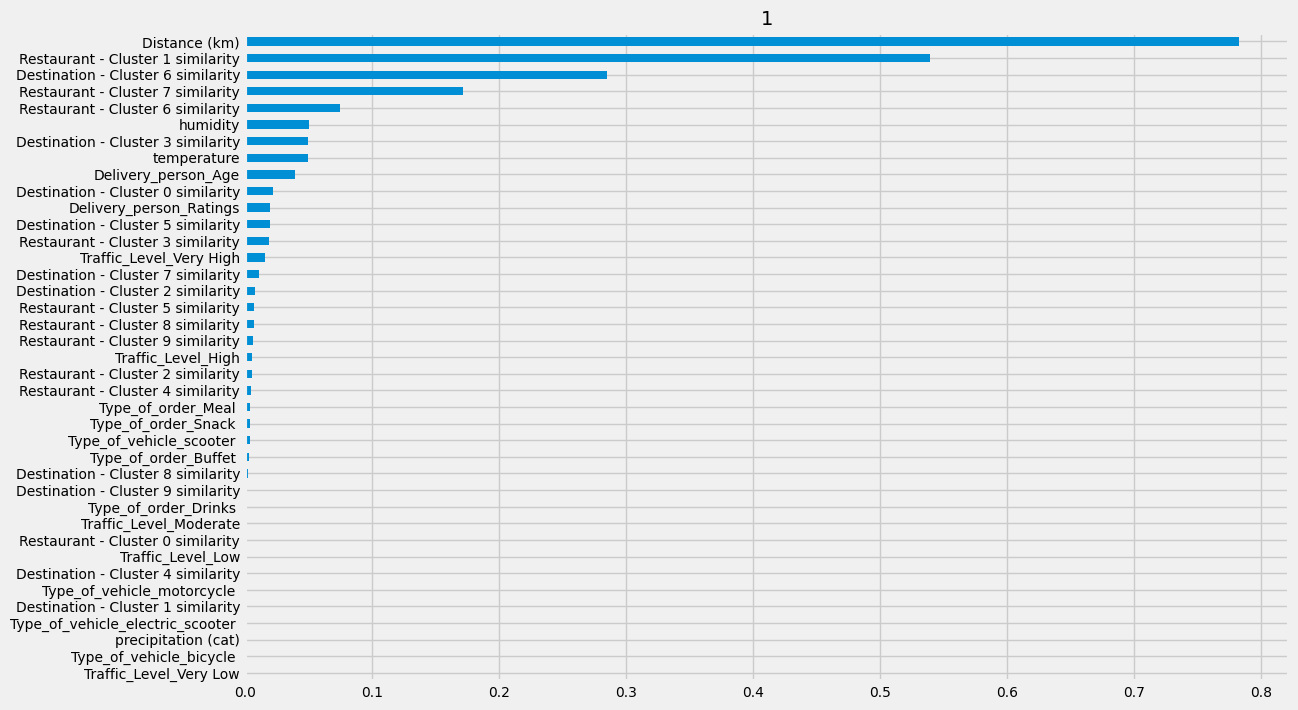

In [30]:
# method='permutation'
x_learner.plot_importance(X=X, tau=xlearner_tau, model_tau_feature=base_algo,
                          normalize=True, method='permutation', features=X.columns)

#### Shapley Values

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

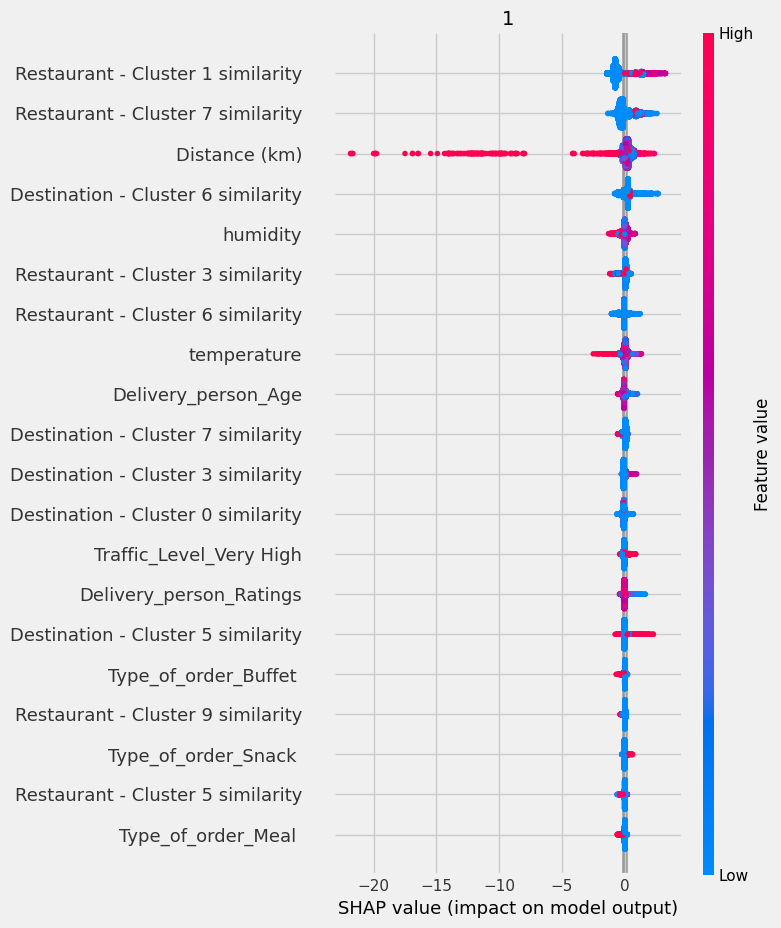

In [31]:
# Without specifying shap_dict
x_learner.plot_shap_values(X=X, tau=xlearner_tau, features=X.columns)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

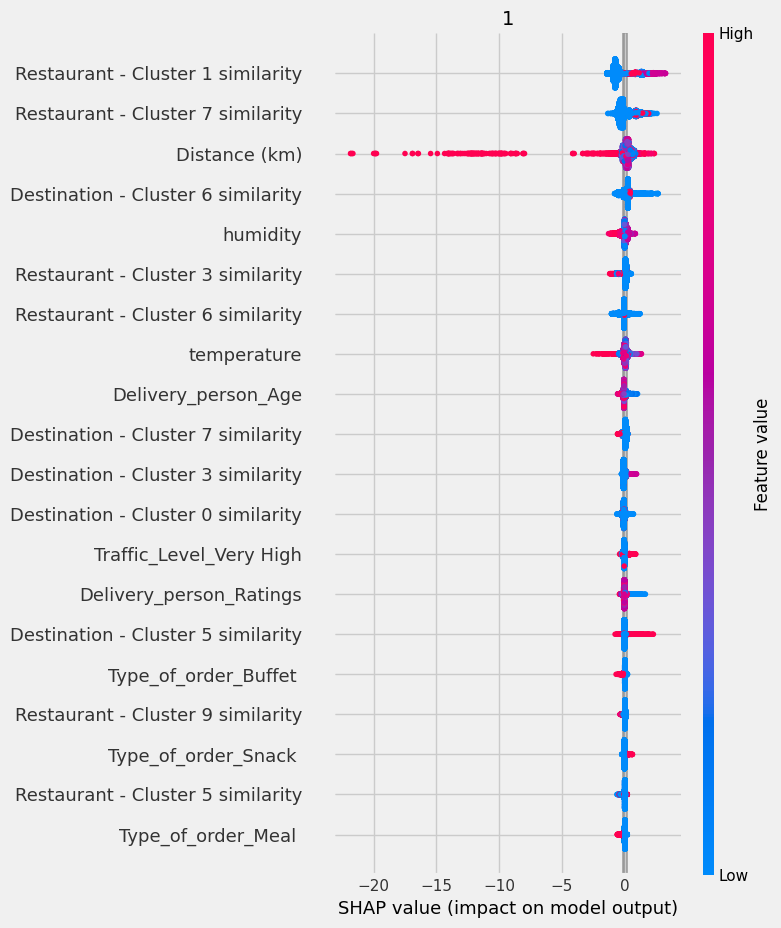

In [32]:
# Specify shap_dict
shap_xlearner = x_learner.get_shap_values(X=X, tau=xlearner_tau)
x_learner.plot_shap_values(X=X, shap_dict=shap_xlearner, features=X.columns)

### 2. XGBTRegressor (ready-to-use T-learner)

In [33]:
learner_t = XGBTRegressor(random_state=42)
ate_t, lb_t, ub_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('ATE (XGBTRegressor): {:.2f} (lb={:.2f}, ub={:.2f})'.format(ate_t[0], lb_t[0], ub_t[0]))

ATE (XGBTRegressor): 1.46 (lb=1.33, ub=1.58)


In [34]:
ite_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

df_cate = pd.DataFrame(X)
df_cate["ITE"] = ite_t
df_cate['Distance'] = df_cate['Distance (km)'].apply(lambda x: 'Close' if x <= 10 else ('Far' if x > 20 else 'Medium'))

cate_by_distance = df_cate.groupby("Distance")["ITE"].agg(CATE='mean')
cate_by_distance

,CATE
Distance,
Close,1.824287
Far,0.985427
Medium,1.409750


#### Feature Importance

In [35]:
base_algo = LGBMRegressor()
tlearner_tau = learner_t.fit_predict(X, treatment, y)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

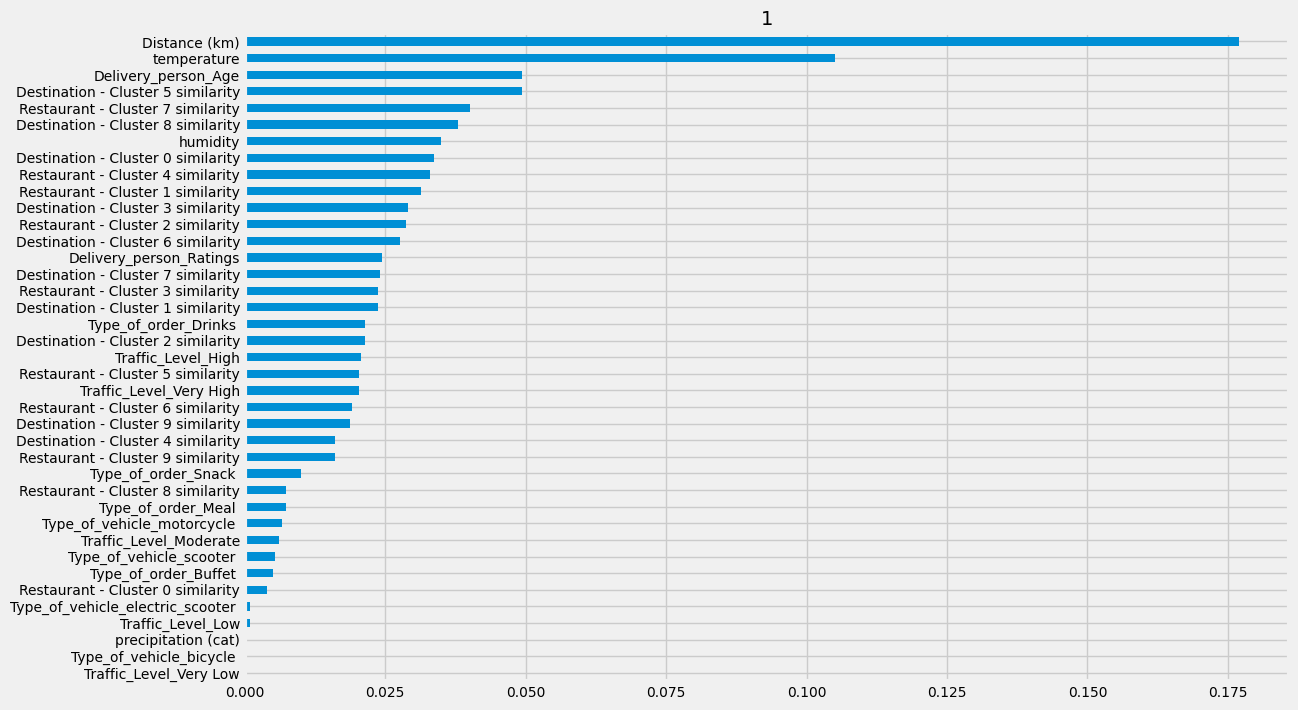

In [36]:
# method='auto'
learner_t.plot_importance(X=X, tau=tlearner_tau, model_tau_feature=base_algo,
                          normalize=True, method='auto', features=X.columns)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

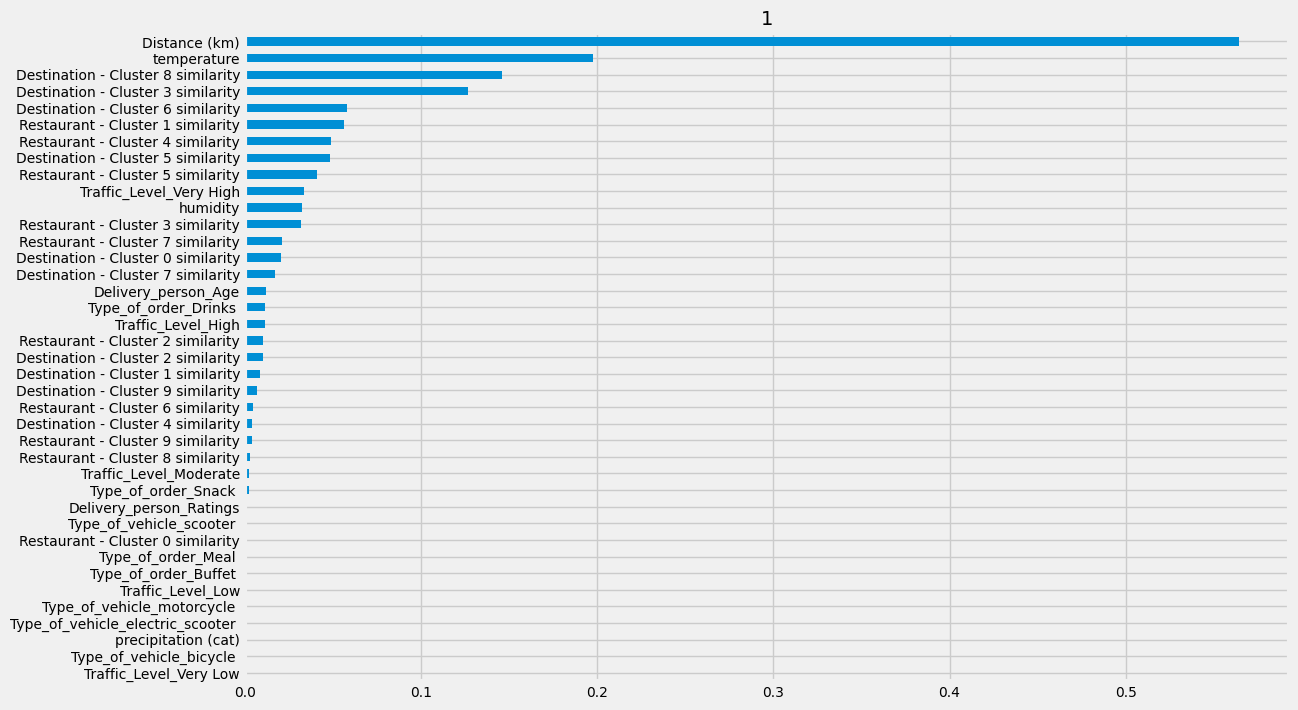

In [37]:
# method='permutation'
learner_t.plot_importance(X=X, tau=tlearner_tau, model_tau_feature=base_algo,
                          normalize=True, method='permutation', features=X.columns)

#### Shapley Values

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

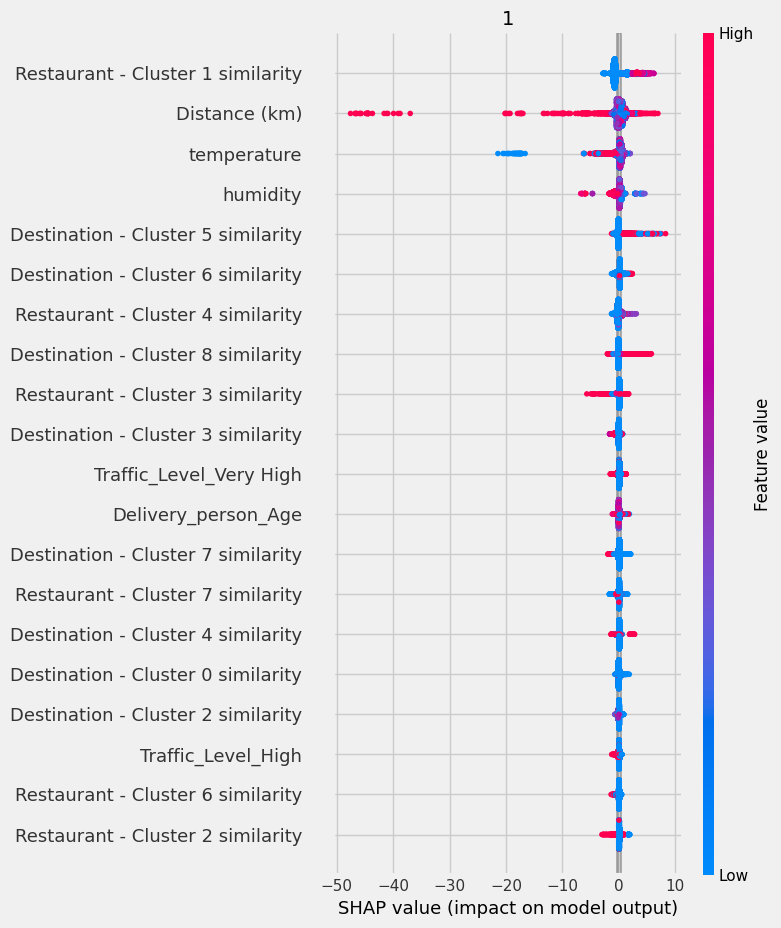

In [38]:
# Without specifying shap_dict
learner_t.plot_shap_values(X=X, tau=tlearner_tau, features=X.columns)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

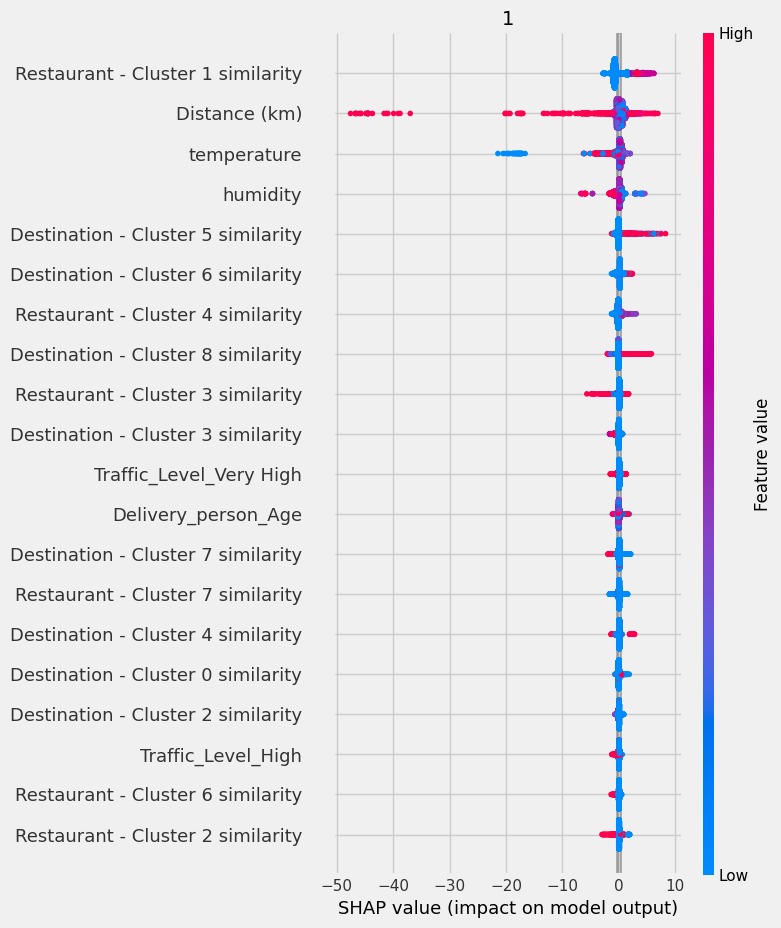

In [39]:
# Specify shap_dict
shap_tlearner = learner_t.get_shap_values(X=X, tau=tlearner_tau)
learner_t.plot_shap_values(X=X, shap_dict=shap_tlearner, features=X.columns)

#### 3. LRSRegressor (ready-to-use S-learner)

In [40]:
learner_s = LRSRegressor()
ate_s, lb_s, ub_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print('ATE (LGBMRegressor): {:.2f} (lb={:.2f}, ub={:.2f})'.format(ate_s[0], lb_s[0], ub_s[0]))

ATE (LGBMRegressor): 1.83 (lb=1.40, ub=2.26)


In [41]:
ite_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

df_cate = pd.DataFrame(X)
df_cate["ITE"] = ite_s
df_cate['Distance'] = df_cate['Distance (km)'].apply(lambda x: 'Close' if x <= 10 else ('Far' if x > 20 else 'Medium'))

cate_by_distance = df_cate.groupby("Distance")["ITE"].agg(CATE='mean')
cate_by_distance

,CATE
Distance,
Close,1.833654
Far,1.833654
Medium,1.833654


#### Feature Importance

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

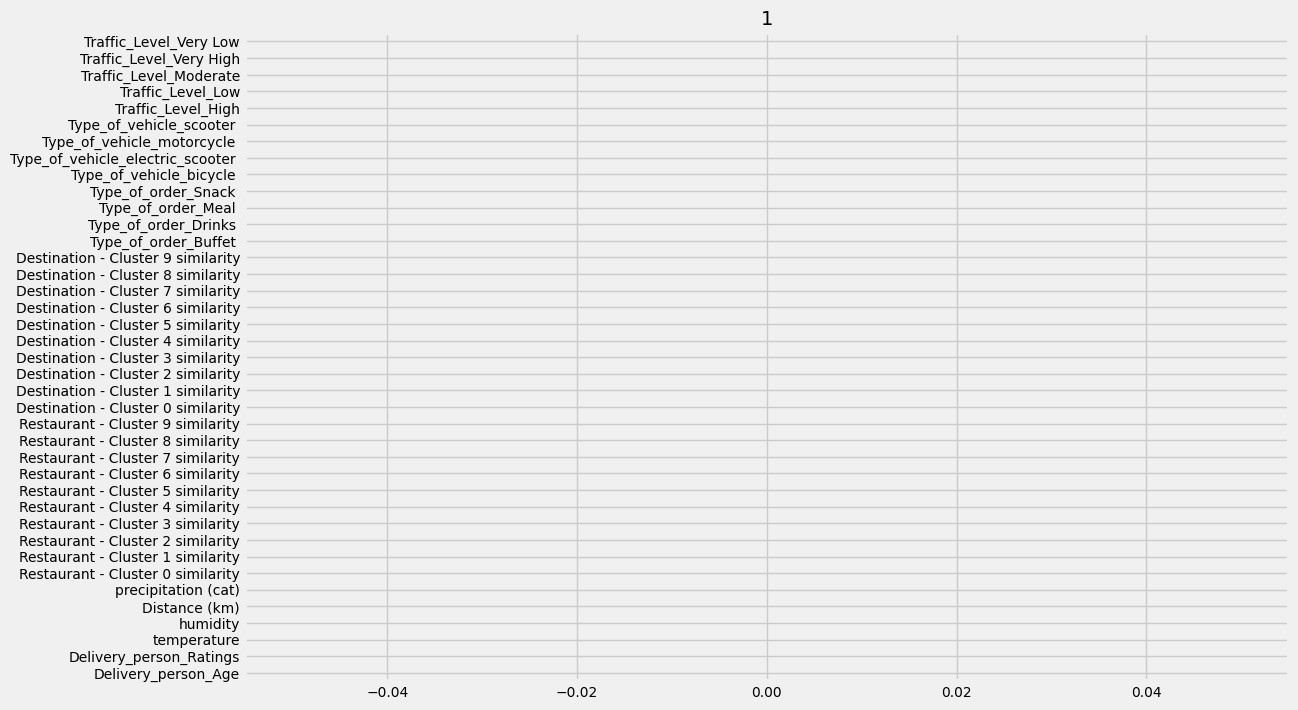

In [42]:
base_algo = LGBMRegressor()
slearner_tau = learner_s.fit_predict(X, treatment, y)

learner_s.plot_importance(X=X, tau=slearner_tau, model_tau_feature=base_algo,
                          normalize=True, method='auto', features=X.columns)

LRSRegressor() assumes a single linear relationship.
It does not model interactions between treatment and covariates.

# **DoWhy**

In [43]:
from dowhy import CausalModel

In [44]:
df_delivery['treatment (weather condition)'] = df_delivery['group_key'].apply(lambda x: 1 if x == 'Treatment' else 0)

model = CausalModel(
    data = df_delivery,
    treatment = "treatment (weather condition)",
    outcome = "Delivery_time",
    common_causes = X.columns.tolist()
)

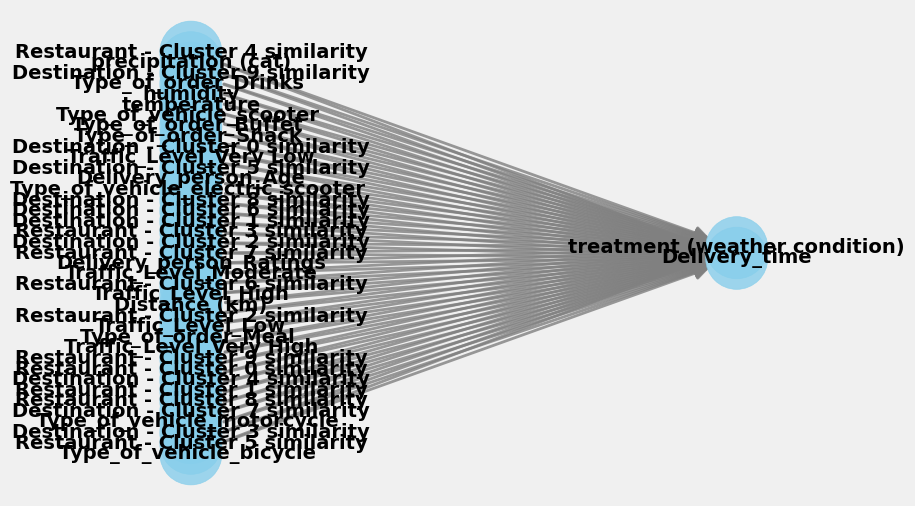

In [45]:
model.view_model()

In [46]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                                                                                   ↪
────────────────────────────────(E[Delivery_time|Type_of_vehicle_bicycle ,Restaurant - Cluster 5 s ↪
d[treatment (weather condition)]                                                                   ↪

↪                                                                                                  ↪
↪ imilarity,Destination - Cluster 3 similarity,Type_of_vehicle_motorcycle ,Destination - Cluster 7 ↪
↪                                                                                                  ↪

↪                                                                                                  ↪
↪  similarity,Restaurant - Cluster 8 similarity,Restaurant - Cluster 1 similarity,Destination - Cl ↪
↪                                                                                

Estimate causal effects using the Backdoor method because a valid set of confounders was found.

In [47]:
# estimating target estimand using a statistical method
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                                                                                   ↪
────────────────────────────────(E[Delivery_time|Type_of_vehicle_bicycle ,Restaurant - Cluster 5 s ↪
d[treatment (weather condition)]                                                                   ↪

↪                                                                                                  ↪
↪ imilarity,Destination - Cluster 3 similarity,Type_of_vehicle_motorcycle ,Destination - Cluster 7 ↪
↪                                                                                                  ↪

↪                                                                                                  ↪
↪  similarity,Restaurant - Cluster 8 similarity,Restaurant - Cluster 1 similarity,Destination - Cl ↪
↪                                

In [48]:
# refutation (robustness check)
refute = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute)

Refute: Use a Placebo Treatment
Estimated effect:3.474266224057522
New effect:-0.03031854720687387
p value:0.98

